中文命名实体识别（Chinese Named Entity Recognition，简称NER）是自然语言处理（Natural Language Processing，简称NLP）中的一个任务，它的目标是从文本中识别出具有特定意义的实体，并将它们分类为预定义的类别。这些实体通常是名词短语，可以是人名、地名、组织名、时间表达式、数量表达式、专有名词等。



实体类别：中文NER中的实体类别可能包括但不限于：

人名（PER）
地名（LOC）
组织名（ORG）
时间表达式（TIME）
数量表达式（QUANTITY）
专有名词（如产品名、事件名等）


一个简单的中文NER示例可能是这样的：

原文：李雷和韩梅梅计划下周去北京旅游。

识别结果：

李雷（人名）
韩梅梅（人名）
下周（时间表达式）
北京（地名）
旅游（事件）


中文NER是构建中文理解和处理系统的基础，对于提高中文文本处理的准确性和效率至关重要。随着深度学习技术的发展，中文NER的准确率和效率都有了显著提升。

In [1]:
from torch.utils.data import Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import time
from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR, StepLR
from torchcrf import CRF
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import Counter
from sklearn.metrics import f1_score

# 设置matplotlib配置参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题


In [2]:
# 'B' 和 'I' 是用来表示实体边界的标记，它们来源于BIO（Begin, Inside, Outside）标记方案

# 人名(PER)、地名(LOC)和机构名(ORG)
# label_dict = {
#     'O': 0,
#     'B-PER': 1,
#     'I-PER': 2,
#     'B-LOC': 3,
#     'I-LOC': 4,
#     'B-ORG': 5,
#     'I-ORG': 6,
#     'padding': 7
# }

label_dict = {
    'O': 0,
    'PER': 1,
    'LOC': 2,
    'ORG': 3,
    'padding': 4
}

In [3]:
# 读取文本文件
with open('data/msra_train_bio.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# 用于存储最终的实体和标签
texts = []

text = []
for line in lines:
    if line == '\n':
        texts.append(text)

        text = []
        label = []
    else:
        parts = line.split('\t')
        text.append(parts[0])

print(len(texts))
# print(texts)

45000


In [4]:
# 统计词频
# 展平二维列表
all_tokens = [token for sublist in texts for token in sublist]

# 统计词频
token_counts = Counter(all_tokens)

print(len(token_counts))

4791


In [5]:
# 创建一个字典，将每个字符映射到一个唯一的整数
char_to_idx = {char: i + 1 for i, char in enumerate(set(''.join(all_tokens)).union({'<PAD>'}))}

In [6]:
class MyDataset(Dataset):
    def __init__(self, file):
        super(MyDataset, self).__init__()
        
        # 读取文本文件
        with open(file, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        # 用于存储最终的实体和标签
        texts = []
        labels = []

        text = []
        label = []
        for line in lines:
            if line == '\n':
                # 将每个字符转换为整数
                encoded_texts = [char_to_idx[char] if char in char_to_idx else 0 for char in text]
                texts.append(encoded_texts)
                try:
                    labels.append([label_dict[num] if num != '' else 0 for num in label])
                except:
                    pass
                text = []
                label = []
            else:
                parts = line.split('\t')
                text.append(parts[0])
#                 label.append(parts[-1].strip())
                label.append(parts[-1].strip() if parts[-1].strip() == 'O' else parts[-1].strip()[2:])
        
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        return self.texts[item], self.labels[item]

In [7]:
dataset = MyDataset('data/msra_test_bio.txt')
text, label = dataset[:]

print(len(dataset))
print(text[0])
print(label[0])

3442
[1533, 1882, 1533, 3772, 2060, 1533, 2229, 2060, 3274, 2966, 1200, 154, 1074, 4025, 1600, 2283, 673, 1848, 3466, 3235, 1874, 673, 1848, 581, 3335, 1958, 592, 1533, 2229, 2060, 3274, 2966, 2975, 1200, 154, 1122, 332, 2229, 3466, 3235, 1074, 170, 4424, 2924, 3967, 818, 2591, 4618, 1469, 1533, 2229, 1882, 125, 2966, 1533, 3772, 4368, 3785, 170, 1300, 2088, 1074, 170, 3235, 625, 268, 1052, 4025, 3164, 1600, 1469, 2088, 2060, 3274, 2966, 4025, 581, 3335, 3254, 2060, 2654, 2324, 3255, 4025, 4521, 1299, 2524]
[3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


最大文本长度: 2427


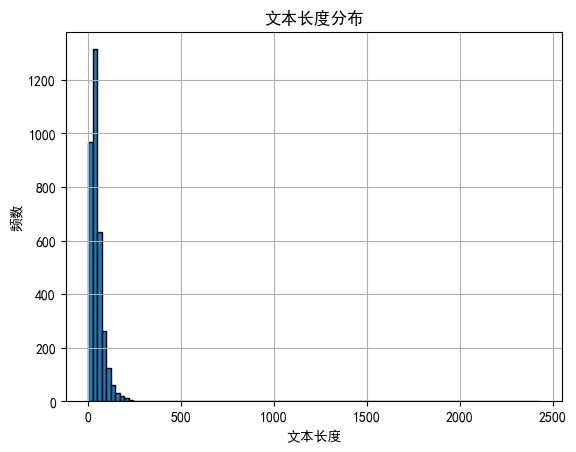

In [8]:
# 收集所有文本长度
lengths = [len(text) for text, label in dataset]

# 计算最大长度
max_length = max(lengths)
print("最大文本长度:", max_length)

# 绘制直方图
plt.hist(lengths, bins=100, edgecolor='black')  # 可以调整bins的数量来改变区间划分
plt.title('文本长度分布')
plt.xlabel('文本长度')
plt.ylabel('频数')
plt.grid(True)
plt.show()

In [ ]:
# 自定义的GRU层
class CostomGRU_layer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CostomGRU_layer, self).__init__()
        # 初始化参数
        self.W_xz = nn.Parameter(torch.randn(input_size, hidden_size))  # 更新门的输入到隐藏层的权重
        self.W_hz = nn.Parameter(torch.randn(hidden_size, hidden_size))  # 更新门的隐藏层到隐藏层的权重

        self.W_xr = nn.Parameter(torch.randn(input_size, hidden_size))  # 重置门的输入到隐藏层的权重
        self.W_hr = nn.Parameter(torch.randn(hidden_size, hidden_size))  # 重置门的隐藏层到隐藏层的权重

        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size))  # 候选隐藏状态的输入到隐藏层的权重
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))  # 候选隐藏状态的隐藏层到隐藏层的权重

        self.hb_z = nn.Parameter(torch.zeros(hidden_size))  # 更新门的偏置
        self.hb_r = nn.Parameter(torch.zeros(hidden_size))  # 重置门的偏置
        self.hb_h = nn.Parameter(torch.zeros(hidden_size))  # 候选隐藏状态的偏置
        
        self.xb_z = nn.Parameter(torch.zeros(hidden_size))  
        self.xb_r = nn.Parameter(torch.zeros(hidden_size))  
        self.xb_h = nn.Parameter(torch.zeros(hidden_size))  

    def forward(self, x, h):
        # 前向传播
        z = torch.sigmoid((torch.matmul(x, self.W_xz) + self.xb_z) + (torch.matmul(h, self.W_hz) + self.hb_z))  # 更新门
        r = torch.sigmoid((torch.matmul(x, self.W_xr) + self.xb_r) + (torch.matmul(h, self.W_hr) + self.hb_r))  # 重置门
        h_tilda = torch.tanh((torch.matmul(x, self.W_xh) + self.xb_h) + r * (torch.matmul(h, self.W_hh) + self.hb_h))  # 候选隐藏状态
        h = z * h + (1 - z) * h_tilda  # 更新隐藏状态
        return h


# 自定义的GRU模型
class CostomGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = CostomGRU_layer(self.input_size, self.hidden_size)

    def forward(self, X, h0=None):
        # x.shape = (batch_size, seq_length, input_size)
        # h0.shape = (1, batch_size, hidden_size)
        # output.shape = (batch_size, seq_length, hidden_size)
        batch_size = X.shape[1]
        self.seq_length = X.shape[0]
        if h0 is None:
            prev_h = torch.zeros([batch_size, self.hidden_size])
            prev_h = prev_h.to(device)
        else:
            prev_h = torch.squeeze(h0, 0)

        output = torch.zeros([self.seq_length, batch_size, self.hidden_size]).to(device)
        for i in range(self.seq_length):
            prev_h = self.gru(X[i], prev_h)
            output[i] = prev_h

        return output, torch.unsqueeze(prev_h, 0)

In [9]:
class Model(nn.Module):
    def __init__(self, input_size, num_class, hidden_size=768):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
#         self.gru = CostomGRU(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_class)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = self.relu(self.embedding(x))
        out, _ = self.gru(x)
        out = self.relu(self.fc1(self.relu(out)))
        out = self.fc2(out)
        return out

In [10]:
batch_size = 32
seq_length = 150
input_size = len(token_counts) + 2
hidden_size = 256

num_class = len(label_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [11]:
x = torch.randint(0, input_size, (seq_length, 1)).to(device)
model = Model(input_size, num_class, hidden_size).to(device)
out = model(x)

# 打印输出张量的形状
print(out.shape)  

torch.Size([150, 1, 5])


In [12]:
from transformers import AutoTokenizer
import torch


def collate_fn(data, max_length=seq_length):
    tokens = [i[0] for i in data]  # 提取所有文本
    labels = [i[1] for i in data]  # 提取所有标签
    
    # 处理文本
    new_tokens = []
    for token in tokens:
        
        # 截断或填充标签以匹配最大序列长度
        new_token = token[:max_length] + [input_size - 1] * (max_length - len(token[:max_length]))
        new_tokens.append(new_token)

    # 将标签列表转换为LongTensor 
    tokens_tensor = torch.LongTensor (new_tokens)

    # 处理标签
    new_labels = []
    for label in labels:
        
        # 截断或填充标签以匹配最大序列长度
        new_label = label[:max_length] + [num_class - 1] * (max_length - len(label[:max_length]))
        new_labels.append(new_label)

    # 将标签列表转换为LongTensor 
    labels_tensor = torch.LongTensor (new_labels)

    return tokens_tensor, labels_tensor

In [13]:
def get_correct_and_total_count(labels, outs):
    
    outs = outs.argmax(dim=2)                   # 获取概率最高的类别作为预测结果
    correct = (outs == labels).sum().item()     # 计算总的正确预测数量
    total = labels.size(0) * labels.size(1)     # 计算总的标签数量

    # 计算除了补充元素以外的正确率
    select = labels != num_class - 1                  # 选择非补充的标签

    labels_non_supplementary = labels[select]                     # 选择非补充的真实标签
    outs_non_supplementary = outs[select]                         # 选择非补充的预测结果
    
    # 计算F1分数
    # F1分数是衡量分类模型精确度的一种指标，它是精确率和召回率的调和平均数，用于在模型的精确性和完整性之间取得平衡。
    f1 = f1_score(labels_non_supplementary.cpu().numpy(), outs_non_supplementary.cpu().numpy(), average='macro')
    
    # 由于labels和outs在过滤后可能不再是二维的，需要调整它们的形状
    labels_non_supplementary = labels_non_supplementary.view(-1)  # 展平为一维
    outs_non_supplementary = outs_non_supplementary.view(-1)  # 展平为一维
    correct_content = (outs_non_supplementary == labels_non_supplementary).sum().item()      # 计算非补充部分的正确预测数量
    total_content = len(labels_non_supplementary)                 # 计算非补充部分的标签数量

    return correct, total, correct_content, total_content, f1


In [14]:
from tqdm import tqdm

def train(dataloader, model, criterion, optimizer, device, scheduler):
    size = len(dataloader.dataset)
    avg_loss = 0
    correct, total, correct_content, total_content = 0, 0, 0, 0
    
    model.train()
#     for batch, (inputs, labels) in enumerate(tqdm(dataloader, desc="Processing")):
    for batch, (inputs, labels) in enumerate(dataloader):
        # 将数据存到显卡
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 得到预测的结果
        outs = model(inputs)
        loss = criterion(outs.view(-1, num_class) , labels.view(-1))
        avg_loss += loss
        # 反向传播，更新模型参数
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        counts = get_correct_and_total_count(labels, outs)
        
        correct += counts[0]
        total += counts[1]
        correct_content += counts[2]
        total_content += counts[3]
        
    # 更新学习率
    scheduler.step()

    # 当一个epoch完了后返回平均 loss
    avg_loss /= size
    avg_loss = avg_loss.detach().cpu().numpy()
    accuracy = correct / total
    accuracy_content = correct_content / total_content
    
    print(f"train: correct = {100 * accuracy:.3f}%, Accuracy: {(100 * accuracy_content):>0.3f}%, Avg loss: {avg_loss:>8f}, f1_score: {counts[4]:>5f}")
    return accuracy_content, avg_loss


def validate(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    # 将模型转为验证模式
    model.eval()
    # 初始化test_loss 和 correct， 用来统计每次的误差
    test_loss = 0
    correct, total, correct_content, total_content = 0, 0, 0, 0
    # 测试时模型参数不用更新，所以no_gard()
    # 非训练， 推理期用到
    with torch.no_grad():
        # 加载数据加载器，得到里面的X（图片数据）和y(真实标签）
        for batch, (inputs, labels) in enumerate(dataloader):
            # 将数据存到显卡
            inputs, labels = inputs.to(device), labels.to(device)

            # 得到预测的结果
            outs = model(inputs)
            loss = loss_fn(outs.view(-1, num_class) , labels.view(-1))
            test_loss += loss

            counts = get_correct_and_total_count(labels, outs)
        
            correct += counts[0]
            total += counts[1]
            correct_content += counts[2]
            total_content += counts[3]

    test_loss /= size
    test_loss = test_loss.detach().cpu().numpy()
    accuracy = correct / total
    accuracy_content = correct_content / total_content
    print(f"valid: correct = {100 * accuracy:.3f}%, Accuracy: {(100 * accuracy_content):>0.3f}%, Avg loss: {test_loss:>8f}, f1_score: {counts[4]:>5f}")
    return accuracy_content, test_loss


def predict(tokens, model, device, max_length=seq_length):
    model = model.to(device)
    
    inputs = []
    for sentence in tokens:
        # 将每个字符转换为整数
        part = [char_to_idx[char] if char in char_to_idx else 0 for char in sentence]
        inputs.append(part)
    
    # 处理文本
    new_inputs = []
    for token in inputs:
        
        # 截断或填充标签以匹配最大序列长度
        new_input = token[:max_length] + [input_size - 1] * (max_length - len(token[:max_length]))
        
        # 将标签列表转换为LongTensor 
        new_input = torch.LongTensor (new_input)
        
        new_inputs.append(new_input)

    preds = []
    
    with torch.no_grad():
        for batch, inputs in enumerate(new_inputs):
            # 拓展为(seq_length, 1) 形状的二维张量
            x_unsqueezed = x.unsqueeze(1)

            # 将数据存到显卡
            inputs = inputs.to(device)
            
            size = inputs.size(0)

            # 得到预测的结果
            outs = model(inputs)
            
            # 获取概率最高的类别作为预测结果
            outs = outs.argmax(dim=-1)     
            
            preds.append(outs)
            
#     preds = torch.cat(preds, dim=0)
    
    preds_txt = []
    for index, pred in enumerate(preds):
        pred = pred[:len(tokens[index])]
        
        # 创建一个从数字索引到标签名称的映射
        idx_to_label = {v: k for k, v in label_dict.items()}

        # 使用映射将数字索引转换为标签名称
        label_strings = [idx_to_label[idx.item()] for idx in pred]
        preds_txt.append(label_strings)
    
    return pred, preds_txt

In [15]:
# # 给训练集和测试集分别创建一个数据集加载器
train_data = MyDataset('data/msra_train_bio.txt')
valid_data = MyDataset('data/msra_test_bio.txt')

train_dataloader = DataLoader(dataset=train_data,
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=collate_fn,
                            drop_last=True)
valid_dataloader = DataLoader(dataset=valid_data,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=collate_fn,
                            drop_last=True)

# 输出使用设备
print(f"Using {device} device")

# 创建模型
model = Model(input_size, num_class, hidden_size).to(device)
model = model.to(device)

# 定义标签损失权重
# class_weights = torch.tensor([1, 20, 20, 20, 20, 20, 20, 0.5]).to(device)
class_weights = torch.tensor([1, 10, 10, 10, 0.01]).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# loss_fn = nn.CrossEntropyLoss()

# 定义优化器
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 定义学习率策略（余弦退火）
# scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-10)

scheduler = StepLR(optimizer, step_size=5, gamma=0.95)

epochs = 50
loss_ = 100
save_root = "models/"
avg_loss = 0

train_accs = []
train_losses = []
val_accs = []
val_losses = []

for t in range(epochs):
    
    print(f"\n----------------------Epoch {t} ----------------------------")

    train_accuracy, avg_loss = train(train_dataloader, model, loss_fn, optimizer, device, scheduler)
    val_accuracy, val_loss = validate(valid_dataloader, model, loss_fn, device)

    train_accs.append(train_accuracy) 
    train_losses.append(avg_loss)
    val_accs.append(val_accuracy)
    val_losses.append(val_loss)

    if avg_loss < loss_:
        loss_ = avg_loss
        torch.save(model.state_dict(), save_root + "model_best.pth")

    torch.save(model.state_dict(), save_root + "model_last.pth")

Using cuda device

----------------------Epoch 0 ----------------------------
train: correct = 26.882%, Accuracy: 84.855%, Avg loss: 0.041828, f1_score: 0.267659
valid: correct = 28.611%, Accuracy: 89.236%, Avg loss: 0.037789, f1_score: 0.239703

----------------------Epoch 1 ----------------------------
train: correct = 34.155%, Accuracy: 87.644%, Avg loss: 0.037045, f1_score: 0.357700
valid: correct = 84.497%, Accuracy: 86.070%, Avg loss: 0.033778, f1_score: 0.314902

----------------------Epoch 2 ----------------------------
train: correct = 92.320%, Accuracy: 84.724%, Avg loss: 0.033948, f1_score: 0.359053
valid: correct = 95.152%, Accuracy: 84.878%, Avg loss: 0.031326, f1_score: 0.313604

----------------------Epoch 3 ----------------------------
train: correct = 94.754%, Accuracy: 83.441%, Avg loss: 0.032057, f1_score: 0.394796
valid: correct = 94.194%, Accuracy: 81.892%, Avg loss: 0.030035, f1_score: 0.322578

----------------------Epoch 4 ----------------------------
train: cor

train: correct = 94.298%, Accuracy: 82.001%, Avg loss: 0.022974, f1_score: 0.498367
valid: correct = 93.973%, Accuracy: 81.201%, Avg loss: 0.022127, f1_score: 0.405809

----------------------Epoch 37 ----------------------------
train: correct = 94.294%, Accuracy: 81.989%, Avg loss: 0.022900, f1_score: 0.493574
valid: correct = 93.734%, Accuracy: 80.458%, Avg loss: 0.022251, f1_score: 0.400936

----------------------Epoch 38 ----------------------------
train: correct = 94.273%, Accuracy: 81.923%, Avg loss: 0.022899, f1_score: 0.562954
valid: correct = 94.033%, Accuracy: 81.389%, Avg loss: 0.022037, f1_score: 0.414639

----------------------Epoch 39 ----------------------------
train: correct = 94.283%, Accuracy: 81.955%, Avg loss: 0.022842, f1_score: 0.528678
valid: correct = 94.174%, Accuracy: 81.830%, Avg loss: 0.021982, f1_score: 0.416993

----------------------Epoch 40 ----------------------------
train: correct = 94.285%, Accuracy: 81.961%, Avg loss: 0.022813, f1_score: 0.548169


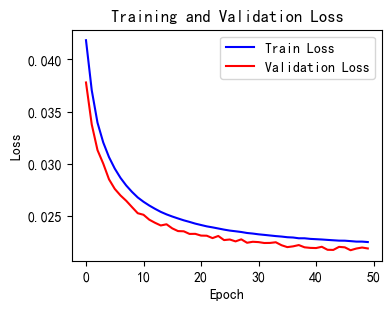

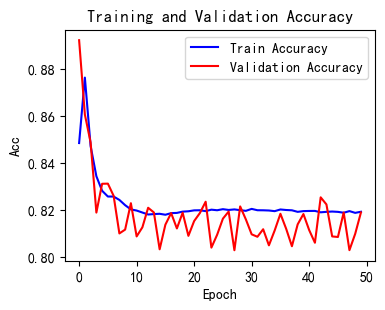

In [16]:
# 绘制训练损失和验证损失曲线
plt.figure(figsize=(4, 3))
 
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制训练损失和验证正确率曲线
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train Accuracy', color='blue')
plt.plot(val_accs, label='Validation Accuracy', color='red')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

# 显示图形
plt.show()

In [17]:
tokens = [
    '在2024年的春天，张伟、李娜和王强三位科学家在中国科学院的资助下，前往云南的西双版纳热带植物园进行生物多样性研究。他们与当地的傣族村民合作，共同探索了这片土地上丰富的植物资源，希望能找到对抗气候变化的新方法。' ,
    '正当朱镕基当选政府总理后第一次在中外记者招待会上，回答外国记者的提问：中国农村是否实行民主选举制度的时候，一位中国电视编导正携带着她的反映中国农村民主选举村委会领导的电视纪录片《村民的选择》（北京电视台摄制，仝丽编导），出现在法国的真实电影节上。',
    '中共中央致中国致公党十一大的贺词各位代表、各位同志：在中国致公党第十一次全国代表大会隆重召开之际，中国共产党中央委员会谨向大会表示热烈的祝贺，向致公党的同志们致以亲切的问候！'
]

save_root = "models/"
model = Model(input_size, num_class, hidden_size).to(device)
model_state_dict = torch.load(save_root + "model_best.pth")

preds, preds_txt = predict(tokens, model, device)
# print(preds)
# print(preds_txt)

In [18]:
for idx, token in enumerate(tokens):
    for num in range(len(token)):
        print(token[num], preds_txt[idx][num])

    print('\n\n')

在 PER
2 O
0 PER
2 O
4 O
年 O
的 O
春 O
天 O
， O
张 O
伟 padding
、 O
李 O
娜 padding
和 padding
王 PER
强 O
三 PER
位 PER
科 PER
学 O
家 O
在 PER
中 O
国 PER
科 PER
学 O
院 PER
的 O
资 O
助 O
下 O
， PER
前 PER
往 PER
云 padding
南 O
的 O
西 padding
双 O
版 O
纳 O
热 O
带 O
植 PER
物 PER
园 O
进 padding
行 PER
生 padding
物 padding
多 O
样 padding
性 padding
研 O
究 PER
。 PER
他 O
们 O
与 padding
当 padding
地 O
的 O
傣 O
族 O
村 O
民 O
合 O
作 padding
， padding
共 O
同 PER
探 O
索 O
了 O
这 PER
片 PER
土 O
地 O
上 O
丰 PER
富 O
的 O
植 O
物 PER
资 PER
源 PER
， PER
希 PER
望 PER
能 PER
找 PER
到 O
对 padding
抗 padding
气 padding
候 PER
变 PER
化 PER
的 O
新 PER
方 O
法 O
。 PER



正 PER
当 PER
朱 padding
镕 padding
基 O
当 padding
选 O
政 O
府 O
总 O
理 O
后 O
第 O
一 O
次 PER
在 PER
中 PER
外 O
记 O
者 O
招 O
待 PER
会 padding
上 padding
， padding
回 O
答 PER
外 O
国 PER
记 PER
者 O
的 O
提 O
问 O
： padding
中 O
国 PER
农 O
村 O
是 O
否 PER
实 O
行 PER
民 O
主 O
选 O
举 O
制 O
度 O
的 O
时 O
候 PER
， PER
一 PER
位 PER
中 PER
国 PER
电 PER
视 O
编 O
导 padding
正 PER
携 PER
带 PER
着 O
她 O
的 O
反 padding
映 O
中 O
国 PER
农 O
村 O
民 O
主 O
选 O
举